# Python Implementation for Ride-Hailing Fare Equation
#### Provide your credentials to the runtime

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


## Use BigQuery through pandas_gbq

In [ ]:
import pandas_gbq
import numpy as np

# Declare the Cloud project ID which will be used throughout this notebook
project_id = "xxx-ecomdata-dev"

# Create a DataFrame from BigQuery
sql = """
WITH oms AS (
  SELECT
    order_id,
    CAST(order_item_ride_distance AS INT64)/1000 AS distance,
    CAST(order_item_ride_duration AS INT64)/60 AS duration,
    order_myr_gmv AS fare,
    order_item_pickup_longitude AS longitude,
    order_item_pickup_latitude AS latitude,
  FROM `xxx-oms-prd.oms_master.oms_MasterTransactionData_Ride`
  WHERE order_booking_at_Local BETWEEN '2024-07-01' AND '2024-07-31'
    AND country = 'Malaysia'
    AND business_type = 'B2C'
    AND order_item_business_type = 'e-hailing'
    AND order_status = 'FULFILMENT_DONE' -- Filter data for completed orders
  ),

zone AS (
  SELECT
    oms.*,
    zonegroup,
    name AS zonename
  FROM oms
  INNER JOIN `xxx-ecomdata-dev.GEOSPATIAL_COMMON.my_autosurge_zones`
  ON ST_CONTAINS(geometry, ST_GEOGPOINT(longitude, latitude))
  WHERE zonegroup = 'Hotspot' -- Filter data for specific hotspot zones
  )

  SELECT distance, duration, fare
  FROM zone
"""
df = pandas_gbq.read_gbq(sql, project_id=project_id, dialect='standard')

df.head()


Downloading: 100%|██████████|


,distance,duration,fare
0,1.0,3.0,6.0
1,42.0,49.0,55.0
2,52.0,49.0,59.0
3,45.0,44.0,60.0
4,12.0,40.0,38.0


## Ride-Hailing Fare Equation

In [ ]:
# Add a column for ones (intercept term)
df["intercept"] = 1
df.head()

,distance,duration,fare,intercept
0,18.0,32.0,35.0,1
1,17.0,31.0,30.0,1
2,16.0,32.0,35.0,1
3,22.0,44.0,59.0,1
4,14.0,30.0,31.0,1


In [ ]:
# Define the independent variables (X) and dependent variable (y)
X = df[["distance", "duration", "intercept"]]
y = df["fare"]

# Use linear regression to find the coefficients
coefficients = np.linalg.lstsq(X, y, rcond=None)[0]

# Extract the coefficients
fare_per_km, fare_per_min, base_fare = coefficients

# Print the equation
print("Equation: Fare = {:.2f} * distance + {:.2f} * duration + {:.2f}".format(fare_per_km, fare_per_min, base_fare))

Equation: Fare = 1.02 * distance + 0.43 * duration + 0.47


## Equation Test

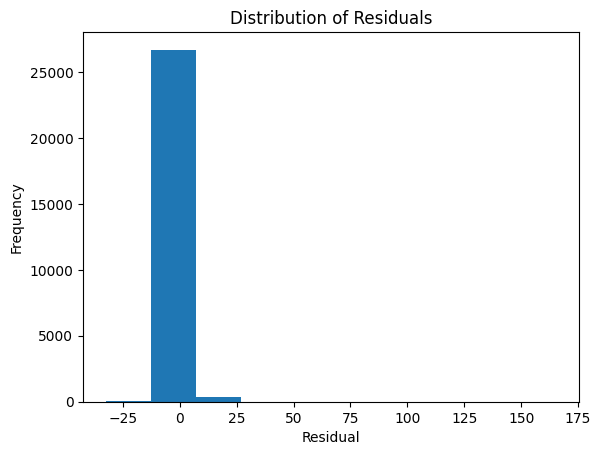

Mean Squared Error: 9.79857166951528


In [ ]:
# Calculate predicted fares
df["predicted_fare"] = fare_per_km * df["distance"] + fare_per_min * df["duration"] + base_fare

# Calculate residuals (difference between actual and predicted)
df["residual"] = df["fare"] - df["predicted_fare"]

# Analyze the residuals
# You can plot a histogram of residuals, calculate mean squared error, etc.
import matplotlib.pyplot as plt
plt.hist(df["residual"])
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df["fare"], df["predicted_fare"])
print("Mean Squared Error:", mse)

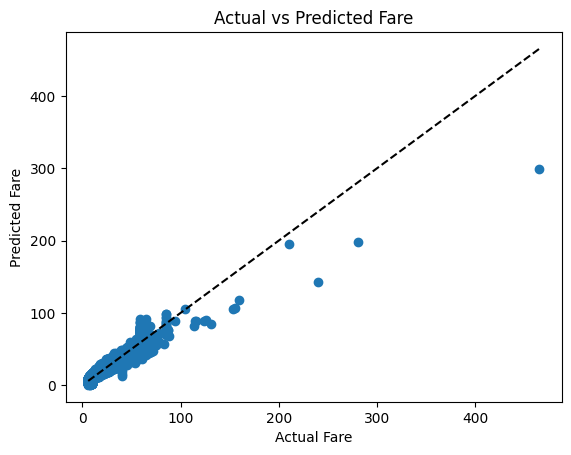

In [ ]:
# Scatter plot of actual vs predicted fare
plt.scatter(df["fare"], df["predicted_fare"])
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Actual vs Predicted Fare")

# Add a diagonal line for reference (perfect predictions)
plt.plot([df["fare"].min(), df["fare"].max()], [df["fare"].min(), df["fare"].max()], 'k--')

plt.show()

## Plot a Normal Distribution Curve of Trip Distance

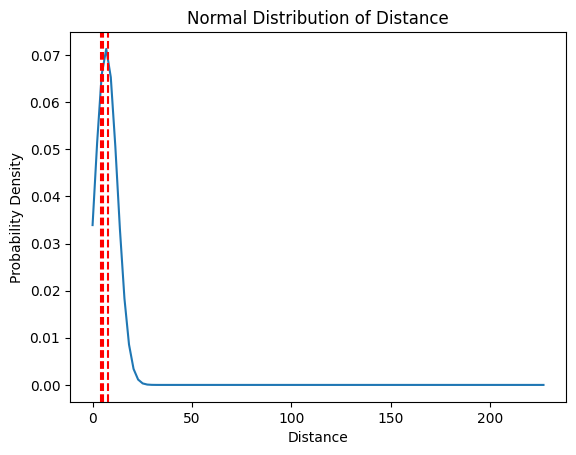

In [ ]:
import scipy.stats as stats

# Calculate percentiles
percentiles = np.percentile(df['distance'], [25, 50, 75])

# Generate data for the normal distribution curve
x = np.linspace(df['distance'].min(), df['distance'].max(), 100)
pdf = stats.norm.pdf(x, loc=df['distance'].mean(), scale=df['distance'].std())

# Plot the normal distribution curve
plt.plot(x, pdf)

# Plot the percentiles
for percentile in percentiles:
  plt.axvline(x=percentile, color='r', linestyle='--')

# Add labels and title
plt.xlabel('Distance')
plt.ylabel('Probability Density')
plt.title('Normal Distribution of Distance')

# Show the plot
plt.show()